# Funções de distribuição das Interrupções
## Objetivo:
- Verificar quais são as funções de distribuição que melhor representam o CHI Total diário;
- Verificar para cada conjunto elétrico e concessionária;

PS. Para queme está interessado somente na análise, há uma capítulo dentro desse notebook dedicado somente a isso. Para utilizá-lo não é necessário fazer a parte antecessora.

In [27]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import polars as pl
import numpy as np
from reliability.Fitters import Fit_Everything
from joblib import Parallel, delayed
from pathlib import Path
from dateutil.relativedelta import relativedelta
import os
from urllib.request import urlopen, urlretrieve
import warnings
from tqdm import tqdm
import os
from datetime import date

pd.set_option('display.max_columns', None)

In [2]:
# Dados disponíveis em: https://dadosabertos.aneel.gov.br/dataset/interrupcoes-de-energia-eletrica-nas-redes-de-distribuicao
dict_filenames = {'intrp_2017': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/246e926b-a686-42fc-b55f-32e4046834de/download/interrupcoes-energia-eletrica-2017.csv',
                  'intrp_2018': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/8fcce0f2-4ea2-42ea-b7ac-00fd8feab03c/download/interrupcoes-energia-eletrica-2018.csv',
                  'intrp_2019': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/965d2abb-91fe-4fab-b463-8c84f2e02188/download/interrupcoes-energia-eletrica-2019.csv',
                  'intrp_2020': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/58201617-8364-4e7f-975d-21f8b8c7436f/download/interrupcoes-energia-eletrica-2020.csv',
                  'intrp_2021': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/42d778de-4a10-4b54-a00a-87c8ff35db6f/download/interrupcoes-energia-eletrica-2021.csv',
                  'intrp_2022': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/7d081751-3f4c-4ede-96b5-1bf2e46b61ca/download/interrupcoes-energia-eletrica-2022.csv',
                  'intrp_2023': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/cce72c2b-a4cb-4b98-818f-3ac56bbf2a78/download/interrupcoes-energia-eletrica-2023.csv',
                  'intrp_2024': 'https://dadosabertos.aneel.gov.br/dataset/ccb25653-f07b-4f28-84c2-62a89d1f5a56/resource/cc091bb8-b308-46b2-98ec-c2fd58e7194b/download/interrupcoes-energia-eletrica-2024.csv',
                 }

In [3]:
# Pasta onde serão armazenados os dados
folder='./dados/'
try:
    os.mkdir(folder)
except:
    pass

# Define a lista de CSV já baixado
ls_csv = [i.split('.csv')[0] for i in os.listdir(folder) if i.endswith('.csv')]

# Somente os arquivos não baixados
filenames_new = dict_filenames.keys() - ls_csv
dict_filenames_new = {k:dict_filenames[k] for k in filenames_new}

# Faz o download dos dataset
pbar = tqdm(dict_filenames_new.items())
for i in pbar:
    pbar.set_description(f"Downloading {i[0]}")
    urlretrieve(i[1], folder+i[0]+'.csv')

0it [00:00, ?it/s]


# Importação dos dados

In [4]:
# Converte em parquet
col_dtypes = {'DatGeracaoConjuntoDados': 'string',
              'IdeConjuntoUnidadeConsumidora': 'Int64',
              'DscConjuntoUnidadeConsumidora': 'string',
              'DscAlimentadorSubestacao': 'string',
              'DscSubestacaoDistribuicao': 'string',
              'NumOrdemInterrupcao': 'string',
              'DscTipoInterrupcao': 'string',
              'IdeMotivoInterrupcao': 'Int64',
              'DatInicioInterrupcao': 'string',
              'DatFimInterrupcao': 'string',
              'DscFatoGeradorInterrupcao': 'string',
              'NumNivelTensao': 'Int64',
              'NumUnidadeConsumidora': 'Int64',
              'NumConsumidorConjunto': 'Int64',
              'NumAno': 'Int64',
              'NomAgenteRegulado': 'string',
              'SigAgente': 'string',
              'NumCPFCNPJ': 'Int64'}

def intrp_to_parquet(filename, col_dtypes=col_dtypes):
    filename_core = filename.split('.csv')[-2]
    
    df_intrp = pd.read_csv(filename, sep=';', decimal=',', 
                           encoding='ISO-8859-1')
    # Formatação das colunas
    df_intrp['NumCPFCNPJ'] = pd.to_numeric(df_intrp['NumCPFCNPJ'], errors='coerce')
    df_intrp = df_intrp.astype(col_dtypes)
    df_intrp['DatGeracaoConjuntoDados'] = pd.to_datetime(df_intrp['DatGeracaoConjuntoDados'])
    df_intrp['DatInicioInterrupcao'] = pd.to_datetime(df_intrp['DatInicioInterrupcao'])
    df_intrp['DatFimInterrupcao'] = pd.to_datetime(df_intrp['DatFimInterrupcao'])
    
    df_intrp.dropna().to_parquet(f'{filename_core}.parquet')

In [5]:
# Define a lista de PARQUET já criados
ls_parquet = [i.split('.parquet')[0] for i in os.listdir(folder) if i.endswith('.parquet')]
# Lista os arquivos que tem CSV e não tem PARQUET
ls_filenames = [f"{folder}{file}"+'.csv' for file in set(ls_csv) - set(ls_parquet)]
# Converte em Parquet
_ = [intrp_to_parquet(filename) for filename in tqdm(ls_filenames)]

0it [00:00, ?it/s]


In [6]:
# # Atualiza o ano corrente
# urlretrieve(dict_filenames['intrp_2024'], folder+'intrp_2024.csv')
# intrp_to_parquet('dados/intrp_2024.csv')

In [7]:
# Concatena todos os parquets
ls_df = [pl.scan_parquet(folder+file+'.parquet').select(col_dtypes.keys()) for file in ls_parquet]

In [8]:
df = pl.concat(ls_df)

In [9]:
# Amostra do df
df.head().collect()

DatGeracaoConjuntoDados,IdeConjuntoUnidadeConsumidora,DscConjuntoUnidadeConsumidora,DscAlimentadorSubestacao,DscSubestacaoDistribuicao,NumOrdemInterrupcao,DscTipoInterrupcao,IdeMotivoInterrupcao,DatInicioInterrupcao,DatFimInterrupcao,DscFatoGeradorInterrupcao,NumNivelTensao,NumUnidadeConsumidora,NumConsumidorConjunto,NumAno,NomAgenteRegulado,SigAgente,NumCPFCNPJ
datetime[ns],i64,str,str,str,str,str,i64,datetime[ns],datetime[ns],str,i64,i64,i64,i64,str,str,i64
2024-03-14 00:00:00,14236,"""TRINDADE""","""TDD-01C5""","""TRINDADE""","""15326228_14086…","""Não Programada…",0,2017-11-29 08:18:37,2017-12-01 08:27:42,"""INTERNO - NAO …",380,1,36413,2017,"""COMPANHIA ENER…","""CELPE …",10835932000108
2024-03-14 00:00:00,14169,"""ILHA DO RETIRO…","""ILR-01L7""","""ILHA DO RETIRO…","""15360608_14111…","""Não Programada…",0,2017-12-23 07:17:30,2017-12-23 08:13:00,"""INTERNO - NAO …",13800,33,24044,2017,"""COMPANHIA ENER…","""CELPE …",10835932000108
2024-03-14 00:00:00,14225,"""SERRA TALHADA""","""SRT-01M2""","""SERRA TALHADA""","""15349415_14103…","""Não Programada…",0,2017-12-15 16:36:38,2017-12-15 22:40:00,"""INTERNO - NAO …",13800,5,52321,2017,"""COMPANHIA ENER…","""CELPE …",10835932000108
2024-03-14 00:00:00,14130,"""BOM JARDIM""","""BJD-01C2""","""BOM JARDIM""","""15368642_14119…","""Não Programada…",0,2017-12-27 20:38:49,2017-12-27 22:43:00,"""INTERNO - NAO …",13800,189,33992,2017,"""COMPANHIA ENER…","""CELPE …",10835932000108
2024-03-14 00:00:00,14235,"""TORITAMA""","""VTE-01V4""","""VERTENTES""","""15349417_14103…","""Não Programada…",0,2017-12-15 16:37:14,2017-12-17 08:00:00,"""INTERNO - NAO …",13800,10,42647,2017,"""COMPANHIA ENER…","""CELPE …",10835932000108


# Dados Auxiliares
Adição de algumas colunas auxiliares

In [11]:
# Colunas Auxiliares
df = df.with_columns(pl.col('DatFimInterrupcao').sub(pl.col('DatInicioInterrupcao')).dt.total_minutes().truediv(60).alias('duracao_h'))
df = df.with_columns(pl.col('duracao_h').mul(pl.col('NumUnidadeConsumidora')).alias('chi'))
df = df.with_columns((pl.col('duracao_h') <= 3/60).alias('fm'))
df = df.with_columns(pl.col('DatInicioInterrupcao').cast(pl.Date).alias('DatInicioInterrupcao_date'))
df = df.with_columns(pl.col('SigAgente').str.strip_chars())

In [13]:
df.head().collect()

DatGeracaoConjuntoDados,IdeConjuntoUnidadeConsumidora,DscConjuntoUnidadeConsumidora,DscAlimentadorSubestacao,DscSubestacaoDistribuicao,NumOrdemInterrupcao,DscTipoInterrupcao,IdeMotivoInterrupcao,DatInicioInterrupcao,DatFimInterrupcao,DscFatoGeradorInterrupcao,NumNivelTensao,NumUnidadeConsumidora,NumConsumidorConjunto,NumAno,NomAgenteRegulado,SigAgente,NumCPFCNPJ,duracao_h,chi,fm,DatInicioInterrupcao_date
datetime[ns],i64,str,str,str,str,str,i64,datetime[ns],datetime[ns],str,i64,i64,i64,i64,str,str,i64,f64,f64,bool,date
2024-03-14 00:00:00,14236,"""TRINDADE""","""TDD-01C5""","""TRINDADE""","""15326228_14086…","""Não Programada…",0,2017-11-29 08:18:37,2017-12-01 08:27:42,"""INTERNO - NAO …",380,1,36413,2017,"""COMPANHIA ENER…","""CELPE""",10835932000108,48.15,48.15,false,2017-11-29
2024-03-14 00:00:00,14169,"""ILHA DO RETIRO…","""ILR-01L7""","""ILHA DO RETIRO…","""15360608_14111…","""Não Programada…",0,2017-12-23 07:17:30,2017-12-23 08:13:00,"""INTERNO - NAO …",13800,33,24044,2017,"""COMPANHIA ENER…","""CELPE""",10835932000108,0.916667,30.25,false,2017-12-23
2024-03-14 00:00:00,14225,"""SERRA TALHADA""","""SRT-01M2""","""SERRA TALHADA""","""15349415_14103…","""Não Programada…",0,2017-12-15 16:36:38,2017-12-15 22:40:00,"""INTERNO - NAO …",13800,5,52321,2017,"""COMPANHIA ENER…","""CELPE""",10835932000108,6.05,30.25,false,2017-12-15
2024-03-14 00:00:00,14130,"""BOM JARDIM""","""BJD-01C2""","""BOM JARDIM""","""15368642_14119…","""Não Programada…",0,2017-12-27 20:38:49,2017-12-27 22:43:00,"""INTERNO - NAO …",13800,189,33992,2017,"""COMPANHIA ENER…","""CELPE""",10835932000108,2.066667,390.6,false,2017-12-27
2024-03-14 00:00:00,14235,"""TORITAMA""","""VTE-01V4""","""VERTENTES""","""15349417_14103…","""Não Programada…",0,2017-12-15 16:37:14,2017-12-17 08:00:00,"""INTERNO - NAO …",13800,10,42647,2017,"""COMPANHIA ENER…","""CELPE""",10835932000108,39.366667,393.666667,false,2017-12-15


# Sumarização diária de cada conjunto
Verificar o CHI diário de cada conjunto.

São criadas colunas auxiliares de `chi_liq` e `chi_exp`, sendo:

- chi_liq : quando **não houve** expurgo --> `IdeMotivoInterrupcao` = 0
- chi_exp : quando **houve** expurgo  --> `IdeMotivoInterrupcao` <> 0

O rótulo é aplicado considerando que a coluna `IdeMotivoInterrupcao` segue a codificação:

- 0 - Não houve expurgo
- 1 - Falha nas instalações da unidade consumidora que não provoque interrupção em instalações de terceiros
- 2 - Interrupção decorrente de obras de interesse exclusivo do consumidor e que afete somente a unidade consumidora do mesmo
- 3 - Interrupção em situação de emergência
- 4 - Suspensão por inadimplemento do consumidor ou por deficiência técnica e/ou de segurança das instalações da unidade consumidora que não provoque interrupção em instalações de terceiros, previstas em regulamentação
- 5 - Vinculadas a programas de racionamento instituídos pela União
- 6 - Ocorridas em dia crítico
- 7 - Oriundas de atuação de esquemas de alívio de carga solicitado pelo ONS
- 8 - Interrupção de origem externa ao sistema de distribuição- 

Também é criado um rótulo de `liq` ou `exp` para classificar o dia de acordo com a predominância de CHI naquele dia.

$$
tipo = 
\begin{cases}
  liq & \text{se } chi\_liq \ge chi\_exp \\
  exp & \text{se } chi\_liq \lt chi\_exp \\
\end{cases}
$$

In [36]:
# Verifica ISE e DC (exp) do restante (liq)
df_sumchi_dias = df.group_by(['SigAgente', 
                              'IdeConjuntoUnidadeConsumidora', 
                              'DatInicioInterrupcao_date']).agg(pl.col('chi').filter(pl.col('IdeMotivoInterrupcao') != 0).sum().alias('chi_exp'),
                                                                pl.col('chi').filter(pl.col('IdeMotivoInterrupcao') == 0).sum().alias('chi_liq'),
                                                                pl.col('chi').sum().alias('chi_tot'),
                                                               )

# Separa os dias em que houve mais expurgo que liq como EXP, senão líquido
df_sumchi_dias = df_sumchi_dias.with_columns(pl.when(pl.col('chi_exp') > pl.col('chi_liq'))\
                                               .then(pl.lit('exp')).otherwise(pl.lit('liq'))\
                                               .alias('tipo'))

df_sumchi_dias = df_sumchi_dias.collect()
df_sumchi_dias.head()

SigAgente,IdeConjuntoUnidadeConsumidora,DatInicioInterrupcao_date,chi_exp,chi_liq,chi_tot,tipo
str,i64,date,f64,f64,f64,str
"""CELPE""",14138,2017-12-15,0.0,105.183333,105.183333,"""liq"""
"""CELPE""",14172,2017-12-27,0.0,1178.683333,1178.683333,"""liq"""
"""CELPE""",14121,2017-12-28,0.0,179.95,179.95,"""liq"""
"""CELPE""",14212,2017-12-28,0.0,3.3,3.3,"""liq"""
"""CELPE""",14132,2017-12-15,0.0,20.866667,20.866667,"""liq"""


## Dados de início e fim de cada CEA
Com o longo histórico de interrupções, podem haver criação e extinção de conjuntos.

São verificados o dia da primeira e última interrupção em cada conjunto.

PS. Em alguns casos a última interrupção termina do dia 01 do mês, isso seria muito raro de acontecer, por isso ajusto para que a data fim do conjunto seja no último dia do mês anterior.

In [37]:
# Verifica as datas iniciais e finais de cada conjunto sigagente
df_cea_datas = df_sumchi_dias.group_by(['IdeConjuntoUnidadeConsumidora', 'SigAgente']).agg(dtini = pl.col('DatInicioInterrupcao_date').min(), 
                                                                                           dtfim = pl.col('DatInicioInterrupcao_date').max(),
                                                                                          )

# Modifica a data fim quando ela termina no dia 1 do mês. A verificar o porque isso ocorre
df_cea_datas = df_cea_datas.with_columns(pl.when(pl.col('dtfim').dt.day() == 1).then(pl.col('dtfim') + pl.duration(days=-1)).otherwise(pl.col('dtfim')))

In [21]:
# Cria uma pasta com os arquivos auxiliares de saída
path = 'output'
p = Path(path)
p.mkdir(parents=True, exist_ok=True)

## Criação do dataset por dia

É verificado o CHI por dia por Conjunto Elétrico ANEEL - CEA e por Agente. 

De posse disso é possível verificar a distribuição do CHI diário por CEA de cada concessionária.

**Importante:** Nem sempre há interrupções todos os dias em todos os CEAs, portanto é necessário preencher o CHI com 0 nos dias em que isso ocorre. Do contrário a distribuição seria afetada.

Serão criado arquivos na pasta `output` a cada 500 iterações com o nome `df_sumchi_dias_full_{it}.parquet`

In [39]:
# Adiciona os dias sem interrupções com valores de chi 0
for idx, row in tqdm(zip(range(len(df_cea_datas)), df_cea_datas.iter_rows()), total=len(df_cea_datas)):
    cea, sigagente, dtini, dtfim = row

    # Seleciona o slice
    df_cea = df_sumchi_dias.filter((pl.col('SigAgente') == sigagente)
                                   & (pl.col('IdeConjuntoUnidadeConsumidora') == cea)
                                  )
    # Cria range de datas
    df_daterange = pl.DataFrame(pl.date_range(start=dtini.replace(day=1),
                                 end = dtfim.replace(day=1) + relativedelta(months=1, days=-1),
                                 interval='1d',
                                 eager=True
                                ).alias('DatInicioInterrupcao_date'))
    
    # Adiciona as datas sem interrupções ao DF original
    df_cea_full = df_daterange.join(df_cea, on='DatInicioInterrupcao_date', how='left')

    # Preenche os valores nulos as datas sem interrupções
    df_cea_full = df_cea_full.with_columns(pl.col('SigAgente').fill_null(sigagente),
                                           pl.col('IdeConjuntoUnidadeConsumidora').fill_null(cea),
                                           pl.col('chi_exp').fill_null(0.0),
                                           pl.col('chi_liq').fill_null(0.0),
                                           pl.col('chi_tot').fill_null(0.0),
                                           # pl.col('tipo').fill_null('liq'),
                                          )

    # Exporta os arquivos a cada 550 iterações
    if idx in range(0,len(df_cea_datas), 500):
        if idx ==0:
            df_sumchi_dias_full = df_cea_full
        else:
            df_sumchi_dias_full.write_parquet(f'{path}/df_sumchi_dias_full_{idx}.parquet')
            df_sumchi_dias_full = df_cea_full
    else:
        df_sumchi_dias_full = pl.concat([df_sumchi_dias_full, df_cea_full])

100%|██████████| 4401/4401 [04:06<00:00, 17.87it/s]


Junta os arquivos auxiliares em `df_sumchi_dias_full.parquet`

In [40]:
# Lista os arquivos auxiliares
ls_files = p.glob('**/df_sumchi_dias_full_*.parquet')
files = [x for x in ls_files]

# Concatena os arquivos auxiliares
if files != []:
    df_sumchi_dias_full = pl.concat([pl.read_parquet(file) for file in tqdm(files)])
    df_sumchi_dias_full.write_parquet(f'{path}/df_sumchi_dias_full.parquet')
    # Remove os arquivos auxiliares
    _ = [os.remove(file) for file in files]
else:
    print('Sem arquivos a serem concatenados.')

100%|██████████| 8/8 [00:00<00:00, 17.78it/s]


In [41]:
# Amostra do df diário
df_sumchi_dias_full.head()

DatInicioInterrupcao_date,SigAgente,IdeConjuntoUnidadeConsumidora,chi_exp,chi_liq,chi_tot,tipo
date,str,i64,f64,f64,f64,str
2017-01-01,"""CEMIG-D""",15281,0.0,4.866667,4.866667,"""liq"""
2017-01-02,"""CEMIG-D""",15281,0.0,29.066667,29.066667,"""liq"""
2017-01-03,"""CEMIG-D""",15281,2807.083333,2807.083333,5614.166667,"""liq"""
2017-01-04,"""CEMIG-D""",15281,0.0,1194.466667,1194.466667,"""liq"""
2017-01-05,"""CEMIG-D""",15281,0.0,619.466667,619.466667,"""liq"""


# Funções de Distribuição

In [650]:
path = 'output'
df_sumchi_dias_full = pl.read_parquet(f'{path}/df_sumchi_dias_full.parquet')

## Funções Auxiliares:

### Função para identificação dos outliers

Essa função visa definir os limites do para caracterização de um CHI como outlier. A regra segue a formulação de Tukey.

In [13]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

### Função de adaptação do TQDM 
Apenas para ver a barra de progresso quando se paraleliza os processos. 

In [652]:
# FONTE: https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution/58936697#58936697
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

### Função para forçar do dtype do dataframe
Formata adequadamente o dataframe de resultados das funções de distribuição

In [653]:
# Força o Dtype no DF
def dtype_force(df, dict_dtypes):
    for col,dtype in dict_dtypes.items():
        if is_numeric_dtype(dtype):
            df.loc[:, col] = pd.to_numeric(df.loc[:, col], errors='coerce')
            df[col] = df[col].astype(dtype)    
    return df

## Função Principal

Devido ao elevado tempo de processamento decorrente da quantidade de dados, foi criada uma função para que o processo possa ser paralelizado.

Separação dos blocos para paralelização. O bloco é composto de 1 CEA e Ano de uma concessionária.

In [654]:
df_sumchi_dias_c = df_sumchi_dias_full.to_pandas()

# Separa os grupo para ajustar uma curva e verificar o quantil de cada dia para cada CEA e SigAgente e Ano
df_grupos = df_sumchi_dias_c.loc[:,['IdeConjuntoUnidadeConsumidora', 'SigAgente', 'DatInicioInterrupcao_date']]
df_grupos['DatInicioInterrupcao_date'] = df_grupos['DatInicioInterrupcao_date'].dt.year
df_grupos = df_grupos.drop_duplicates()

Ajusta das funções de distribuição daquele item (CEA, Ano, Concessionária) e exporta para um arquivo de resultados.
Posteriormente cada um desses arquivos vai ser concatenado em 1 para facilitar a interpretação. 

Exportando a cada iteração é possível ter checkpoints que podem ser úteis em caso de parada inesperada do processo, evitando assim que o tempo já gasto processando tenha que ser retomado do 0.

In [4]:
def calc_prob(idx,row):
    # Transformação de variáveis 
    cea = row['IdeConjuntoUnidadeConsumidora']
    sigagente = row['SigAgente']
    ano = row['DatInicioInterrupcao_date']
    # Selecção dos dados de análise
    df_cea = df_sumchi_dias_c.loc[df_sumchi_dias_c['DatInicioInterrupcao_date'].dt.year == ano].query("(SigAgente == @sigagente) & (IdeConjuntoUnidadeConsumidora == @cea)")
    
    # Definição dos Limites de Outliers
    lr, ur = outlier_treatment(df_cea['chi_tot'])
    chi_clean = df_cea.query("(chi_tot > @lr) \
                              & (chi_tot < @ur)")['chi_tot'].to_numpy().flatten()
    
    # Quantidade mínima de pontos distintos para aplicar a distribuição
    if len(set(chi_clean)) > 4:
        # Ajusta as curvas de probalidades
        warnings.filterwarnings("ignore")
        fit_ev = Fit_Everything(failures=chi_clean, 
                                show_histogram_plot=False, 
                                show_probability_plot=False, 
                                show_PP_plot=False, 
                                show_best_distribution_probability_plot=False,
                                print_results=False
                               )
        warnings.filterwarnings("default")
        
        # Guarda os parâmetros das distribuições
        try:
            func_pars = fit_ev.results.copy()
            func_pars['ano'] = ano
            func_pars['SigAgente'] = sigagente
            func_pars['IdeConjuntoUnidadeConsumidora'] = cea
        except:
            func_pars = []
            pass
    
        #Dicionário para formatação das colunas
        dict_dtypes = {'Alpha':       pd.Float64Dtype(),
                       'Beta':        pd.Float64Dtype(),
                       'Gamma':       pd.Float64Dtype(),
                       'Alpha 1':     pd.Float64Dtype(),
                       'Beta 1':      pd.Float64Dtype(),
                       'Alpha 2':     pd.Float64Dtype(),
                       'Beta 2':      pd.Float64Dtype(),
                       'Proportion 1':pd.Float64Dtype(),
                       'DS':          pd.Float64Dtype(),
                       'Mu':          pd.Float64Dtype(),
                       'Sigma':       pd.Float64Dtype(),
                       'Lambda':      pd.Float64Dtype(),
                       'Log-likelihood': pd.Float64Dtype(),
                       'AICc':        pd.Float64Dtype(),
                       'BIC':         pd.Float64Dtype(),
                       'AD':          pd.Float64Dtype(),
                       'Distribution':pd.StringDtype(),
                       'optimizer':   pd.StringDtype(),
                       'ano':         pd.Int64Dtype(),
                       'SigAgente':   pd.StringDtype(),
                       'IdeConjuntoUnidadeConsumidora': pd.Int64Dtype(),
                      }
        func_pars = dtype_force(func_pars, dict_dtypes)
        
        # Exporta os arquivos a cada iteração
        file_path = Path(f"{path}/df_func_pars_{idx}.parquet")
        try:
            func_pars.to_parquet(file_path)#, sep='|', decimal=',', encoding='ISO-8859-1')
        except:
            print('Erro na exportação do ', row)
            pass
    
    else:
        print('erro ', row)            

In [ ]:
# Executa a rotina de forma paralelizada.
with tqdm_joblib(tqdm(total=len(df_grupos))) as progress_bar:
    Parallel(n_jobs=-1)(delayed(calc_prob)(idx,row) for idx,row in df_grupos.iterrows())

## Junção dos arquivos de saída

Verifica os arquivos já processados e junta em um arquivo de saída `df_func_pars_full.parquet`. 

Ao final são excluídos esses arquivos parciais.

In [953]:
# Lista os arquivos auxiliares
ls_files = p.glob('**/df_func_pars_*.parquet')
files = [x for x in ls_files]

# Concatena os arquivos auxiliares
df_func_pars_full = pl.concat([pl.read_parquet(file) for file in tqdm(files)])
df_func_pars_full.write_parquet(f'{path}/df_func_pars_full.parquet')

100%|██████████| 32/32 [00:00<00:00, 128.17it/s]


In [959]:
print('Qtd de arquivos deve ser igual a: ', df_func_pars_full[['ano','SigAgente','IdeConjuntoUnidadeConsumidora']].n_unique())

Qtd de arquivos deve ser igual a:  20648


In [957]:
# Remove os arquivos auxiliares 
if input('ATENÇÃO VC IRÁ DELETAR ARQUIVOS. Digite "S" se deseja continuar.') == 'S':
    _ = [os.remove(file) for file in files]
else:
    print('Vc não deletou os arquivos')

ATENÇÃO VC IRÁ DELETAR ARQUIVOS. Digite "S" se deseja continuar. S


In [960]:
# Seleciona um Agente e Conjunto para verificar a distribuição
df_func_pars_full.filter((pl.col('SigAgente') == 'COPEL-DIS')
                         & (pl.col('IdeConjuntoUnidadeConsumidora') == 14678)
                         & (pl.col('ano') == 2023)
                        )

Distribution,Alpha,Beta,Gamma,Alpha 1,Beta 1,Alpha 2,Beta 2,Proportion 1,DS,Mu,Sigma,Lambda,Log-likelihood,AICc,BIC,AD,optimizer,ano,SigAgente,IdeConjuntoUnidadeConsumidora,__index_level_0__
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,str,i64,i64
"""Weibull_CR""",null,null,null,2022.176574,0.883554,7743.95558,15.068022,null,null,null,null,null,-2853.788547,5715.699045,5730.809664,0.944853,"""TNC""",2023,"""COPEL-DIS""",14678,0
"""Weibull_Mixtur…",null,null,null,1428.186234,1.037766,6679.864287,5.639066,0.870451,null,null,null,null,-2852.304934,5714.793355,5733.650581,0.315159,"""TNC""",2023,"""COPEL-DIS""",14678,0
"""Exponential_1P…",null,null,null,null,null,null,null,null,null,null,null,0.000494,-2867.897514,5737.807113,5741.603171,2.609414,"""TNC""",2023,"""COPEL-DIS""",14678,0
"""Gamma_3P""",2370.358988,0.850034,8.0499,null,null,null,null,null,null,null,null,null,-2863.515522,5733.103993,5744.455472,1.132716,"""TNC""",2023,"""COPEL-DIS""",14678,0
"""Exponential_2P…",null,null,8.0499,null,null,null,null,null,null,null,null,0.000496,-2866.569758,5737.17588,5744.755801,2.780632,"""TNC""",2023,"""COPEL-DIS""",14678,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Loglogistic_2P…",1146.882686,1.352393,null,null,null,null,null,null,null,null,null,null,-2882.46416,5768.964685,5776.544606,1.57736,"""TNC""",2023,"""COPEL-DIS""",14678,0
"""Lognormal_3P""",null,null,0.0,null,null,null,null,null,null,6.970417,1.299679,null,-2880.940396,5767.95374,5779.305219,1.927715,"""TNC""",2023,"""COPEL-DIS""",14678,0
"""Loglogistic_3P…",1146.882686,1.352393,0.0,null,null,null,null,null,null,null,null,null,-2882.46416,5771.001269,5782.352748,1.57736,"""TNC""",2023,"""COPEL-DIS""",14678,0


# Análise da distribuição

In [46]:
import pandas as pd
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from reliability.Distributions import Gamma_Distribution, Normal_Distribution, Weibull_Distribution
from reliability.Fitters import Fit_Gamma_2P, Fit_Normal_2P, Fit_Weibull_3P
from reliability.Other_functions import make_right_censored_data, histogram

In [47]:
path = 'output'
p = Path(path)

In [49]:
# Importa o arquivo de chi diário
df_sumchi_dias_c = pl.read_parquet(f'{path}/df_sumchi_dias_full.parquet').to_pandas()

# Separa os grupo para ajustar uma curva e verificar o quantil de cada dia para cada CEA e SigAgente e Ano
df_grupos = df_sumchi_dias_c.loc[:,['IdeConjuntoUnidadeConsumidora', 'SigAgente', 'DatInicioInterrupcao_date']]
df_grupos['DatInicioInterrupcao_date'] = df_grupos['DatInicioInterrupcao_date'].dt.year
df_grupos = df_grupos.drop_duplicates()
df_sumchi_dias_c.head()

,DatInicioInterrupcao_date,SigAgente,IdeConjuntoUnidadeConsumidora,chi_exp,chi_liq,chi_tot,tipo
0,2017-01-01,CEMIG-D,15281,0,4.86667,4.86667,liq
1,2017-01-02,CEMIG-D,15281,0,29.0667,29.0667,liq
2,2017-01-03,CEMIG-D,15281,2807.08,2807.08,5614.17,liq
3,2017-01-04,CEMIG-D,15281,0,1194.47,1194.47,liq
4,2017-01-05,CEMIG-D,15281,0,619.467,619.467,liq


In [50]:
# Importa o arquivo de parâmetro das funções ajustadas
df_func_pars_full = pd.read_parquet(f'{path}/df_func_pars_full.parquet')
df_func_pars_full = df_func_pars_full.drop(columns=['__index_level_0__'])
df_func_pars_full.head()

,Distribution,Alpha,Beta,Gamma,...,optimizer,ano,SigAgente,IdeConjuntoUnidadeConsumidora
0,Gamma_3P,470.217,0.525824,0.733233,...,TNC,2022,CEMIG-D,15254
1,Weibull_3P,183.839,0.6482,0.733233,...,TNC,2022,CEMIG-D,15254
2,Weibull_Mixture,NaN,NaN,NaN,...,TNC,2022,CEMIG-D,15254
3,Weibull_CR,NaN,NaN,NaN,...,TNC,2022,CEMIG-D,15254
4,Weibull_2P,189.365,0.672087,NaN,...,TNC,2022,CEMIG-D,15254


In [51]:
# Faz o Ranking com base no AICc
df_func_pars_full['rank']  = df_func_pars_full.groupby(['SigAgente','IdeConjuntoUnidadeConsumidora','ano'])['AICc'].rank(method='dense')#.astype('Int64') 

In [52]:
# Transforma em uma tabela de Distribuição x Ranking
df_func_sum = df_func_pars_full.groupby(['Distribution', 'rank']).agg(qtd=('SigAgente', 'count')).reset_index()
df_func_sum['rank'] = df_func_sum['rank'].astype('int') 
df_func_pivot = df_func_sum.pivot_table(index='Distribution', columns='rank', values='qtd').sort_values(by=1, ascending=False)
df_func_pivot.head()

rank,1,2,3,4,...,13,14,15,16
Distribution,,,,,,,,,
Weibull_Mixture,8861,3865,2789,2258,...,98,12,32,3
Weibull_CR,5993,5419,2763,3069,...,70,19,6,NaN
Gamma_3P,4819,4766,5450,2390,...,1,NaN,NaN,NaN
Weibull_3P,611,4581,5720,6449,...,NaN,NaN,NaN,NaN
Exponential_2P,144,332,684,694,...,7628,17,NaN,NaN


In [53]:
# Função para ordenar as distribuições pelo melhor desempenho no ranking
def sort_rank_dist(data):
    max_index_used = []
    for i in range(len(data)):
        max_index = data.drop(max_index_used).iloc[:, i].idxmax()
        if i ==0 :
            max_index_used = [max_index]
        else:
            max_index_used = max_index_used + [max_index]
        # print(max_index)
    return max_index_used

In [54]:
# Ordena as distribuições pelo melhor desempenho no ranking
data = df_func_pivot.fillna(0).cumsum(axis=1)
dist_ordered = sort_rank_dist(data)

## Observação 1
- Nota-se uma dominância das 4 primeiras funções em relação as demais
- A função de distribuição Normal está entre as piores a serem utilizadas

In [55]:
# Plota a tabela ordenada e a apresenta como mapa de calor
cm = sns.color_palette("coolwarm", as_cmap=True)
df_func_pivot.loc[dist_ordered].astype('Int64').style.background_gradient(cmap=cm)

rank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Distribution,,,,,,,,,,,,,,,,
Weibull_Mixture,8861,3865,2789,2258,627,469,405,360,585,132,89,72,98,12,32,3
Weibull_CR,5993,5419,2763,3069,817,653,865,480,240,147,82,51,70,19,6,
Gamma_3P,4819,4766,5450,2390,720,760,737,499,177,344,11,2,1,,,
Weibull_3P,611,4581,5720,6449,2000,620,420,231,27,12,3,2,,,,
Gamma_2P,13,96,622,2044,6370,3025,2927,898,1293,1073,2159,134,25,,,
Weibull_2P,50,205,442,942,5339,8286,2104,2007,997,144,122,41,,,,
Weibull_DS,,1,21,82,312,2747,9540,2328,3407,1510,307,233,185,3,,
Lognormal_2P,31,471,636,745,940,1430,941,5457,2088,3898,868,3111,48,15,,
Lognormal_3P,76,644,695,885,1474,604,417,1605,4993,729,3212,1139,4098,72,33,


## Observação 2
- Não há grandes diferenças de performance dentre as 4 melhores funções de distribuição
- A Exponential_2P já começa a apresentar uma cauda longa, não sendo indicada.
- As 2 melhores são misturas de funções Weibull
- Gamma_3P e Weibull_3P são as melhores opções de funções de formulação tradicional.

In [56]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = ["/usr/share/fonts/truetype/roboto/unhinted/RobotoTTF/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [57]:
# Personalização dos gráficos
import matplotlib as mpl
# https://matplotlib.org/stable/users/explain/customizing.html#customizing-with-style-sheets

# plt.style.use('fivethirtyeight')
plt.style.use(['default'])

dict_plot_attr = {'axes.titlesize' : 24,
                  'axes.labelsize' : 20,
                  'axes.spines.left': True, 
                  'axes.spines.bottom': True,
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'lines.linewidth' : 2,
                  'lines.markersize' : 10,
                  'xtick.labelsize' : 16,
                  'ytick.labelsize' : 16,
                  'font.family' : 'Roboto',
                  'font.style': 'normal'
                 }
plt.style.use(dict_plot_attr)

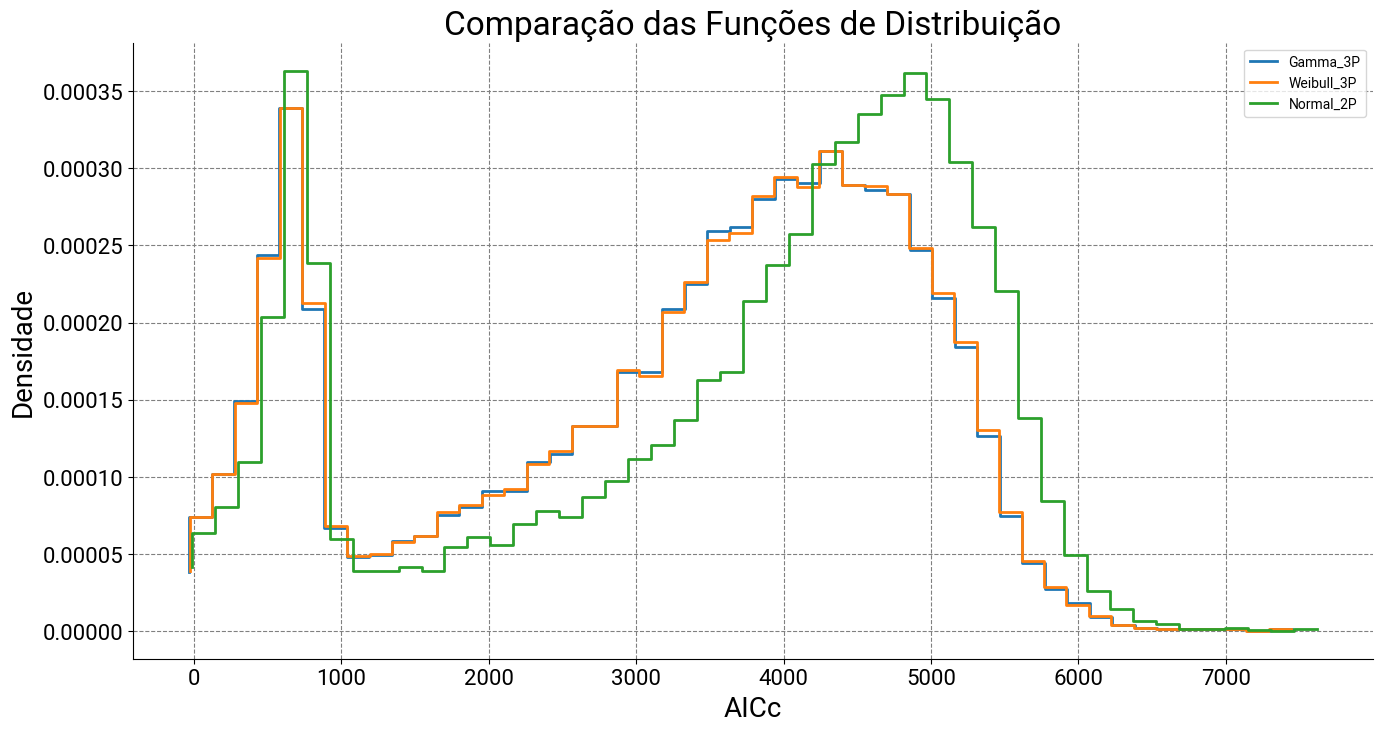

In [58]:
# Plota a distribuição do AICc para as TOP 5 melhores funções distribuição
fig, ax = plt.subplots(1,1, figsize=(16,8), sharex=True, sharey=True)

parameter = 'AICc'
funcs = df_func_pivot.loc[dist_ordered].index[[2,3,13]]
for func in funcs:
    df_audit = df_func_pars_full.query("Distribution == @func")[parameter].dropna()
    lr, ur = outlier_treatment(df_audit)
    parameter_clean = df_audit.loc[(df_audit > lr) & (df_audit < ur)]
    hist, bin_edges = np.histogram(parameter_clean, bins=50, density=True)
    ax.step(bin_edges[:-1], hist, label=func)

plt.legend()
plt.grid(True, linestyle='--', color='gray')
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))
ax.set_xlabel('AICc')
ax.set_ylabel('Densidade')
ax.set_title('Comparação das Funções de Distribuição')
plt.savefig('melhores_funcoes_intrp_histogram.png', format='png')
plt.show()

In [60]:
def plot_histogram(data, title):
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    histogram(data, axes=ax)
    
    mean = np.mean(data)
    median = np.median(data)

    df_pars = df_func_pars_full.query("(ano == @ano) \
                                       & (SigAgente == @sigagente) \
                                       & (IdeConjuntoUnidadeConsumidora == @cea) \
                                       & (Distribution == 'Weibull_3P') \
                                       ")
    gf = Weibull_Distribution(alpha = df_pars['Alpha'].values,
                              beta =  df_pars['Beta'].values,
                              gamma =  df_pars['Gamma'].values
                             ).PDF()
    
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Média: ' + str(round(mean)))
    ax.axvline(median, color='b', linestyle='dotted', linewidth=2, label='Mediana: ' + str(round(median)))

    ax.set_ylim([0,0.0015])
    ax.set_xlim([0,26000])
    ax.legend()
    plt.title(title)
    plt.savefig("test.png", format="png")
    return gf

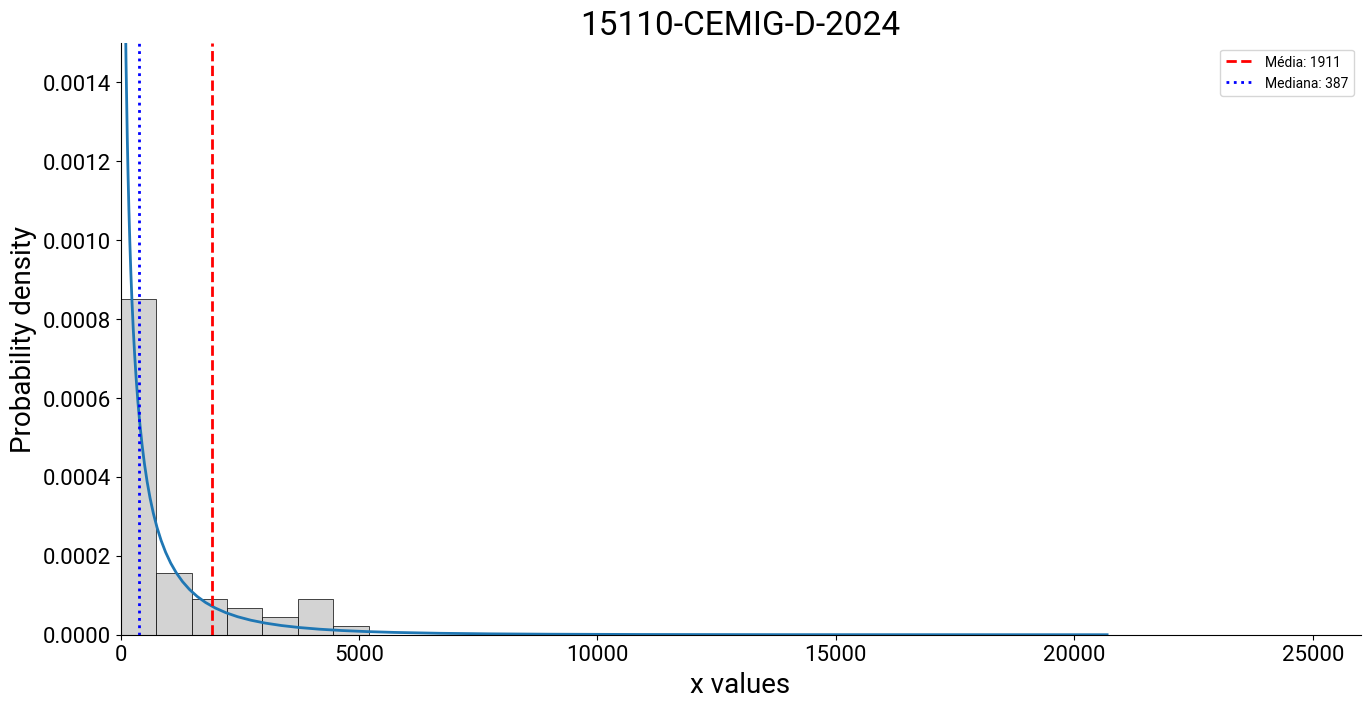

In [61]:
# Gera Gráficos selecionado casos aleatórios de Weibull_3P

df_grupos_weibull = df_func_pars_full.query("Distribution == 'Weibull_3P'")[['IdeConjuntoUnidadeConsumidora', 'SigAgente', 'ano']]
row = df_grupos_weibull.iloc[np.random.randint(len(df_grupos_weibull))]

# Transformação de variáveis 
cea = row['IdeConjuntoUnidadeConsumidora']
sigagente = row['SigAgente']
# ano = row['DatInicioInterrupcao_date']
ano = row['ano']
# Selecção dos dados de análise
df_cea = df_sumchi_dias_c.loc[df_sumchi_dias_c['DatInicioInterrupcao_date'].dt.year == ano].query("(SigAgente == @sigagente) & (IdeConjuntoUnidadeConsumidora == @cea)")
gf = plot_histogram(df_cea['chi_tot'].to_numpy(),
               str(cea) + '-' + str(sigagente) + '-' + str(ano)
              )
# print(str(cea) + '-' + str(sigagente) + '-' + str(ano))